<a href="https://colab.research.google.com/github/SUrooba/CV-Asignmnet01/blob/main/CV-term-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/matterport/Mask_RCNN.git

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [3]:
!python3 setup.py install

python3: can't open file 'setup.py': [Errno 2] No such file or directory


In [4]:
!pip install 'h5py==2.10.0' --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220527125636 requires keras<2.9,>=2.8.

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/Colab Notebooks/Mask_RCNN

[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/Mask_RCNN'
/content


In [7]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [8]:
!pip install -U keras==2.1.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import tensorflow
import skimage
print(tensorflow.__version__, skimage.__version__)

1.15.2 0.18.3


In [10]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.5'

In [11]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd

import torch
import scipy.io
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

from itertools import islice

In [12]:
%cd /content/drive/MyDrive/Colab Notebooks
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/content/drive/MyDrive/Colab Notebooks


**LOADING DATA**

In [13]:
# -------------------- Function to load dataset folder paths according to mode --------------------
def load_dataset_paths(mode):
    if mode == "train":
        CONSEP_IMAGES_PATH = '/content/drive/MyDrive/project_dataset/CoNSeP/Train/Images/'
        CONSEP_LABELS_PATH = '/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/'
        CONSEP_OVERLAY_PATH = '/content/drive/MyDrive/project_dataset/CoNSeP/Train/Overlay/'
        
        CPM17_IMAGES_PATH = '/content/drive/MyDrive/project_dataset/cpm17/train/Images/'
        CPM17_LABELS_PATH = '/content/drive/MyDrive/project_dataset/cpm17/train/Labels/'
        CPM17_OVERLAY_PATH = '/content/drive/MyDrive/project_dataset/cpm17/train/Overlay/'
    
    elif mode =="test":
        CONSEP_IMAGES_PATH = '/content/drive/MyDrive/project_dataset/CoNSeP/Test/Images/'
        CONSEP_LABELS_PATH = '/content/drive/MyDrive/project_dataset/CoNSeP/Test/Labels/'
        CONSEP_OVERLAY_PATH = '/content/drive/MyDrive/project_dataset/CoNSeP/Test/Overlay/'
        
        CPM17_IMAGES_PATH = '/content/drive/MyDrive/project_dataset/cpm17/test/Images/'
        CPM17_LABELS_PATH = '/content/drive/MyDrive/project_dataset/cpm17/test/Labels/'
        CPM17_OVERLAY_PATH = '/content/drive/MyDrive/project_dataset/cpm17/test/Overlay/'
    
    return CONSEP_IMAGES_PATH, CONSEP_LABELS_PATH, CONSEP_OVERLAY_PATH, CPM17_IMAGES_PATH, CPM17_LABELS_PATH, CPM17_OVERLAY_PATH

In [14]:
class ConsepConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU. Batch size is (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 7  # background + nucleus

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 640

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 64, 128, 256)  # anchor side in pixels

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 100

    # set number of epoch
    STEPS_PER_EPOCH = 1

    # set validation steps 
    VALIDATION_STEPS = 1
    
consep_config = ConsepConfig()
consep_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                20
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [48]:
class Cpm17Config(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU. Batch size is (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + nucleus

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 896
    IMAGE_MAX_DIM = 896

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 64, 128, 256)  # anchor side in pixels

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 100

    # set number of epoch
    STEPS_PER_EPOCH = 1

    # set validation steps 
    VALIDATION_STEPS = 1
    
cpm17_config = Cpm17Config()
cpm17_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  896
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  896
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [896 896   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [49]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [51]:
class CoNSePDataset(utils.Dataset):
    
    def load_shapes(self, mode):
        self.mode = mode
        # Add classes
        self.add_class("shapes", 1, "other")
        self.add_class("shapes", 2, "inflammatory")
        self.add_class("shapes", 3, "healthy epithelial")
        self.add_class("shapes", 4, "dysplastic/malignant epithelial")
        self.add_class("shapes", 5, "fibroblast")
        self.add_class("shapes", 6, "muscle")
        self.add_class("shapes", 7, "endothelial")

        # Loading all images file names from train or test folder
        images_files = os.listdir(CONSEP_IMAGES_PATH)

        # If mode is not test then split data into train and val
        if mode != "test":
          train_size = int(len(images_files)*0.8)
          val_size = len(images_files) - train_size

          it = iter(images_files)
          slices = [sli for sli in (list(islice(it, 0, i)) for i in [train_size, val_size])]
          train_images_files = slices[0]
          val_images_files = slices[1]

        # Load images with respect to mode
        if mode == "train":
          for i in range (0, len(train_images_files)):
              id_ = train_images_files[i][6:-4]
              img_path = CONSEP_IMAGES_PATH + train_images_files[i]
              self.add_image("shapes", image_id=id_, path=img_path)
        
        elif mode == "val":
          for i in range (0, len(val_images_files)):
              id_ = val_images_files[i][6:-4]
              img_path = CONSEP_IMAGES_PATH + val_images_files[i]
              self.add_image("shapes", image_id=id_, path=img_path)
        
        elif mode == "test":
          for i in range (0, len(images_files)):
              id_ = images_files[i][5:-4]
              img_path = CONSEP_IMAGES_PATH + images_files[i]
              self.add_image("shapes", image_id=id_, path=img_path)
        
        def load_image(self, image_id):
            info = self.image_info[image_id]
            info = info.get("id")

            if self.mode == "train":
                path = CONSEP_IMAGES_PATH + "train_" + str(info)
            elif self.mode == "test":
                path = CONSEP_IMAGES_PATH + "test_" + str(info)
            
            print(path)
            
            img = imread(path + '.png')
            img = resize(img, (consep_config.IMAGE_SHAPE[0], consep_config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)

            return img

        def image_reference(self, image_id):
            """Return the shapes data of the image."""
            info = self.image_info[image_id]
            if info["source"] == "shapes":
                return info["shapes"]
            else:
                super(self.__class__).image_reference(self, image_id)
                
    def __len__(self):
        return len(os.listdir(CONSEP_IMAGES_PATH))
    
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID."""
        info = self.image_info[image_id]
        info = info.get("id")

        if self.mode != "test":
            path = CONSEP_LABELS_PATH + "train_" + str(info)
        else:
            path = CONSEP_LABELS_PATH + "test_" + str(info)
        
        print(path)

        mask_ = scipy.io.loadmat(path + '.mat')['inst_map']
        mask_ = mask_.reshape(mask_.shape[0], mask_.shape[1])
        unique_masks = np.unique(mask_)[1:]
        number_of_masks = len(unique_masks)

        mask_ = resize(mask_, (cpm17_config.IMAGE_SHAPE[0], cpm17_config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
        masks = [(mask_ == v) for v in unique_masks]
        mask = np.stack(masks, axis=-1).astype('float')

        # Map class names to class IDs
        class_ids = np.ones(number_of_masks, dtype=int)
        
        return mask, class_ids.astype(np.int32)
    
    def load_label(self, image_id):
        """Generate instance overlay for shapes of the given image ID."""
        info = self.image_info[image_id]
        info = info.get("id")

        if self.mode != "test":
            path = CONSEP_LABELS_PATH + "train_" + str(info)
        else:
            path = CONSEP_LABELS_PATH + "test_" + str(info)

        label = scipy.io.loadmat(path + '.mat')

        return label

    def load_overlay(self, image_id):
        """Generate instance overlay for shapes of the given image ID."""
        info = self.image_info[image_id]
        info = info.get("id")

        if self.mode != "test":
            path = CONSEP_OVERLAY_PATH + "train_" + str(info)
        else:
            path = CONSEP_OVERLAY_PATH + "test_" + str(info)
        
        print(path)
            
        overlay = imread(path + '.png')
        overlay = resize(overlay, (consep_config.IMAGE_SHAPE[0], consep_config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)

        return overlay

In [52]:
class CPM17Dataset(utils.Dataset):
    
    def load_shapes(self, mode):
        # Add classes
        self.add_class("shapes", 1, "nuclei")

        # Loading all images file names from train or test folder
        images_files = os.listdir(CPM17_IMAGES_PATH)

        # If mode is not test then split data into train and val
        if mode != "test":
          train_size = int(len(images_files)*0.8)
          val_size = len(images_files) - train_size

          it = iter(images_files)
          slices = [sli for sli in (list(islice(it, 0, i)) for i in [train_size, val_size])]
          train_images_files = slices[0]
          val_images_files = slices[1]

        # Load images with respect to mode
        if mode == "train":
          for i in range (0, len(train_images_files)):
              id_ = train_images_files[i][6:-4]
              img_path = CPM17_IMAGES_PATH + train_images_files[i]
              self.add_image("shapes", image_id=id_, path=img_path)
        
        elif mode == "val":
          for i in range (0, len(val_images_files)):
              id_ = val_images_files[i][6:-4]
              img_path = CPM17_IMAGES_PATH + val_images_files[i]
              self.add_image("shapes", image_id=id_, path=img_path)
        
        elif mode == "test":
          for i in range (0, len(images_files)):
              id_ = images_files[i][5:-4]
              img_path = CPM17_IMAGES_PATH + images_files[i]
              self.add_image("shapes", image_id=id_, path=img_path)
        
        def load_image(self, image_id):
            info = self.image_info[image_id]
            info = info.get("id")

            path = CPM17_IMAGES_PATH + "image_" + str(info)
            print(path)
            img = imread(path + '.png')
            img = resize(img, (cpm17_config.IMAGE_SHAPE[0], cpm17_config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)

            return img

        def image_reference(self, image_id):
            """Return the shapes data of the image."""
            info = self.image_info[image_id]
            if info["source"] == "shapes":
                return info["shapes"]
            else:
                super(self.__class__).image_reference(self, image_id)
                
    def __len__(self):
        return len(os.listdir(CPM17_IMAGES_PATH))
    
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID."""
        info = self.image_info[image_id]
        info = info.get("id")

        path = CPM17_LABELS_PATH + "image_" + str(info)
        print(path)

        mask_ = scipy.io.loadmat(path + '.mat')['inst_map']
        mask_ = mask_.reshape(mask_.shape[0], mask_.shape[1])
        unique_masks = np.unique(mask_)[1:]
        number_of_masks = len(unique_masks)

        mask_ = resize(mask_, (cpm17_config.IMAGE_SHAPE[0], cpm17_config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
        masks = [(mask_ == v) for v in unique_masks]
        mask = np.stack(masks, axis=-1).astype('float')

        # Map class names to class IDs
        class_ids = np.ones(number_of_masks, dtype=int)
        
        return mask, class_ids.astype(np.int32)

    def load_label(self, image_id):
        """Generate instance overlay for shapes of the given image ID."""
        info = self.image_info[image_id]
        info = info.get("id")

        path = CPM17_LABELS_PATH + "image_" + str(info)
        label = scipy.io.loadmat(path + '.mat')

        return label

    def load_overlay(self, image_id):
      """Generate instance overlay for shapes of the given image ID."""
      info = self.image_info[image_id]
      info = info.get("id")

      path = CPM17_OVERLAY_PATH + "image_" + str(info)
      print(path)
      overlay = imread(path + '.png')
      overlay = resize(overlay, (cpm17_config.IMAGE_SHAPE[0], cpm17_config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)

      return overlay

In [53]:
# Getting paths for train mode
CONSEP_IMAGES_PATH, CONSEP_LABELS_PATH, CONSEP_OVERLAY_PATH, CPM17_IMAGES_PATH, CPM17_LABELS_PATH, CPM17_OVERLAY_PATH = load_dataset_paths(mode="train")

In [54]:
# Training dataset
consep_dataset_train = CoNSePDataset()
consep_dataset_train.load_shapes("train")
consep_dataset_train.prepare()

# Validation dataset
consep_dataset_val = CoNSePDataset()
consep_dataset_val.load_shapes("val")
consep_dataset_val.prepare()

In [55]:
# Training dataset
cpm17_dataset_train = CPM17Dataset()
cpm17_dataset_train.load_shapes("train")
cpm17_dataset_train.prepare()

# Validation dataset
cpm17_dataset_val = CPM17Dataset()
cpm17_dataset_val.load_shapes("val")
cpm17_dataset_val.prepare()

/content/drive/MyDrive/project_dataset/CoNSeP/Train/Overlay/train_27


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/MyDrive/project_dataset/CoNSeP/Train/Overlay/train_15


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/MyDrive/project_dataset/CoNSeP/Train/Overlay/train_23


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


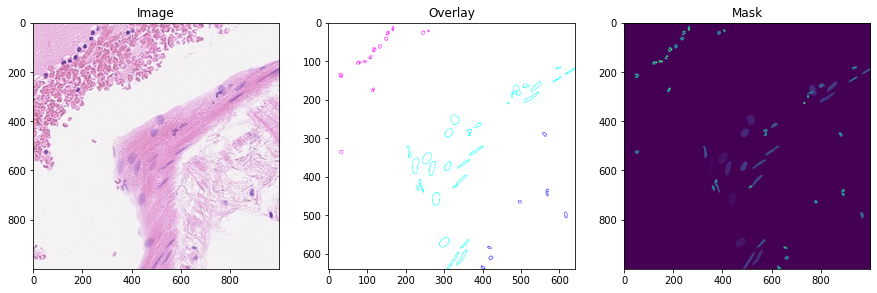

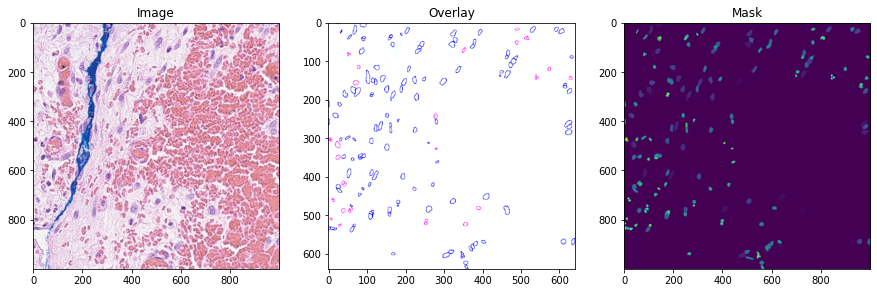

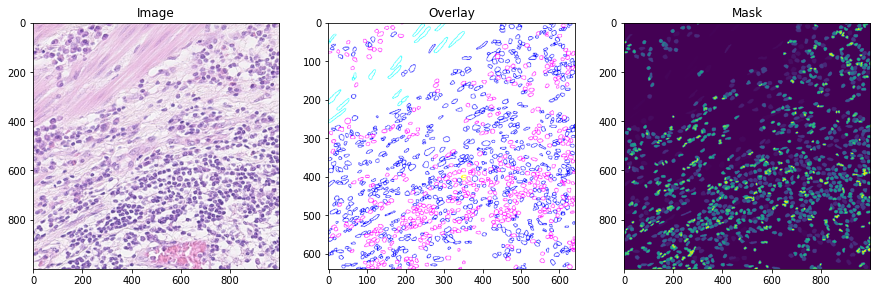

In [56]:
# Load and display random train samples
image_ids = np.random.choice(consep_dataset_train.image_ids, 3)

for image_id in image_ids:
    image = consep_dataset_train.load_image(image_id)
    label = consep_dataset_train.load_label(image_id)
    overlay = consep_dataset_train.load_overlay(image_id)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.title('Overlay')
    plt.imshow(overlay)
    plt.subplot(1, 3, 3)
    plt.title('Mask')
    plt.imshow(label['inst_map'])

/content/drive/MyDrive/project_dataset/CoNSeP/Train/Overlay/train_5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


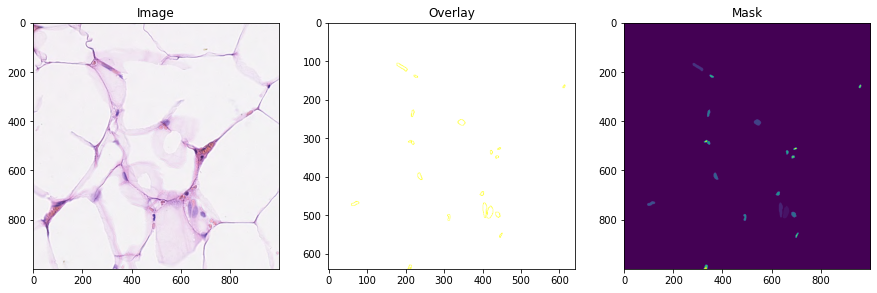

In [57]:
# Load and display random val samples
image_ids = np.random.choice(consep_dataset_val.image_ids, 1)

for image_id in image_ids:
    image = consep_dataset_val.load_image(image_id)
    label = consep_dataset_val.load_label(image_id)
    overlay = consep_dataset_val.load_overlay(image_id)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.title('Overlay')
    plt.imshow(overlay)
    plt.subplot(1, 3, 3)
    plt.title('Mask')
    plt.imshow(label['inst_map'])

/content/drive/MyDrive/project_dataset/cpm17/train/Overlay/image_13


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/MyDrive/project_dataset/cpm17/train/Overlay/image_02


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/MyDrive/project_dataset/cpm17/train/Overlay/image_09


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


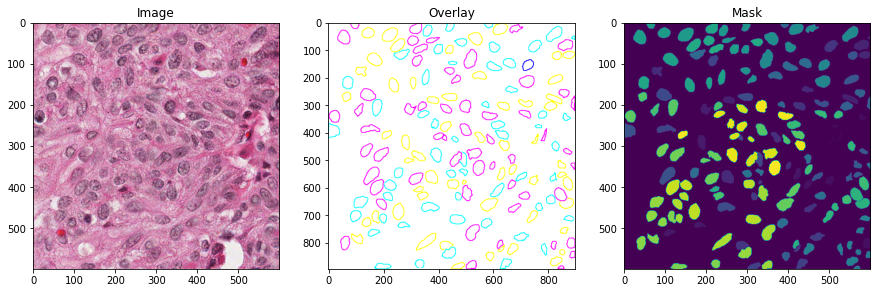

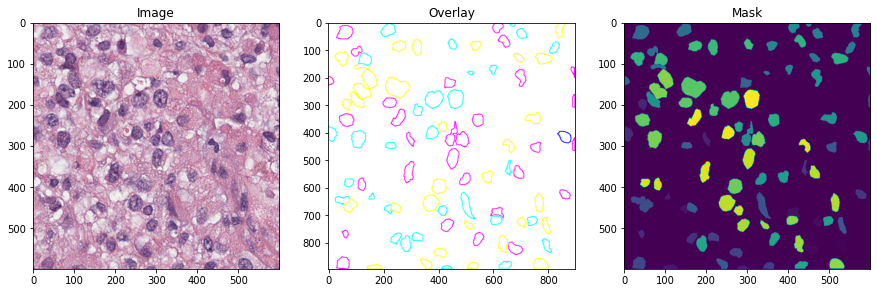

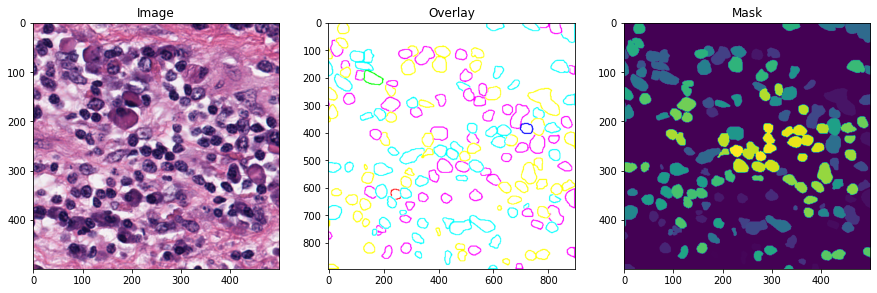

In [58]:
# Load and display random train samples
image_ids = np.random.choice(cpm17_dataset_train.image_ids, 3)

for image_id in image_ids:
    image = cpm17_dataset_train.load_image(image_id)
    label = cpm17_dataset_train.load_label(image_id)
    overlay = cpm17_dataset_train.load_overlay(image_id)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.title('Overlay')
    plt.imshow(overlay)
    plt.subplot(1, 3, 3)
    plt.title('Mask')
    plt.imshow(label['inst_map'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/MyDrive/project_dataset/cpm17/train/Overlay/image_06


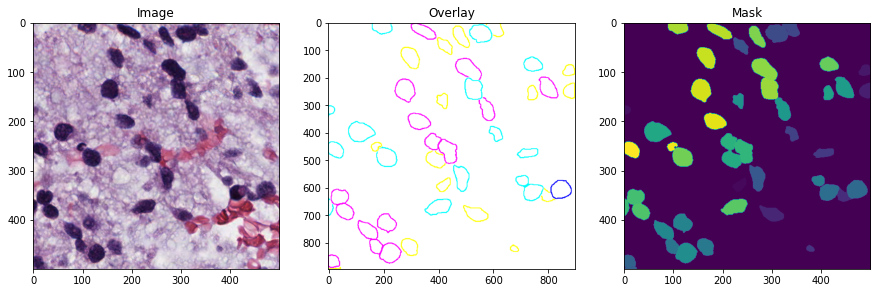

In [59]:
# Load and display random val samples
image_ids = np.random.choice(cpm17_dataset_val.image_ids, 1)

for image_id in image_ids:
    image = cpm17_dataset_val.load_image(image_id)
    label = cpm17_dataset_val.load_label(image_id)
    overlay = cpm17_dataset_val.load_overlay(image_id)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.title('Overlay')
    plt.imshow(overlay)
    plt.subplot(1, 3, 3)
    plt.title('Mask')
    plt.imshow(label['inst_map'])

In [26]:
# Create model for consep in training mode
consep_model = modellib.MaskRCNN(mode="training", config=consep_config, model_dir=MODEL_DIR)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [60]:
# Create model for cpm17 in training mode
cpm17_model = modellib.MaskRCNN(mode="training", config=cpm17_config, model_dir=MODEL_DIR)

In [61]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    consep_model.load_weights(consep_model.get_imagenet_weights(), by_name=True)
    cpm17_model.load_weights(cpm17_model.get_imagenet_weights(), by_name=True)

elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    consep_model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
    cpm17_model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    consep_model.load_weights(cpm17_model.find_last()[1], by_name=True)
    cpm17_model.load_weights(cpm17_model.find_last()[1], by_name=True)

# Training
Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all" `to train all layers.

In [30]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.            
consep_model.train(consep_dataset_train, consep_dataset_val,
            learning_rate=consep_config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Colab Notebooks/logs/shapes20220612T1742/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistri

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/train_16
/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/train_1
Epoch 1/1


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/train_4


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/train_11


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/train_9


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/train_5
/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/train_10


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/train_12
/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/train_25


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/train_18


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/train_6
/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/train_27


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/train_24
1/1 [==============================] - 98s 98s/step - loss: 12.1143 - rpn_class_loss: 5.6758 - rpn_bbox_loss: 3.2476 - mrcnn_class_loss: 3.1909 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 7.8515 - val_rpn_class_loss: 1.2271 - val_rpn_bbox_loss: 4.8755 - val_mrcnn_class_loss: 1.7490 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00



/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/train_19


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/train_17


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/train_26


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/train_3


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/train_13


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/train_14


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


/content/drive/MyDrive/project_dataset/CoNSeP/Train/Labels/train_23


In [62]:
cpm17_model.train(cpm17_dataset_train, cpm17_dataset_val,
            learning_rate=cpm17_config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Colab Notebooks/logs/shapes20220612T1840/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistri

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

/content/drive/MyDrive/project_dataset/cpm17/train/Labels/image_28
/content/drive/MyDrive/project_dataset/cpm17/train/Labels/image_04
Epoch 1/1


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


/content/drive/MyDrive/project_dataset/cpm17/train/Labels/image_26


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


/content/drive/MyDrive/project_dataset/cpm17/train/Labels/image_17
/content/drive/MyDrive/project_dataset/cpm17/train/Labels/image_06


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


/content/drive/MyDrive/project_dataset/cpm17/train/Labels/image_03


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


/content/drive/MyDrive/project_dataset/cpm17/train/Labels/image_01
1/1 [==============================] - 115s 115s/step - loss: 400.1847 - rpn_class_loss: 12.2069 - rpn_bbox_loss: 386.2200 - mrcnn_class_loss: 0.2103 - mrcnn_bbox_loss: 0.9872 - mrcnn_mask_loss: 0.5603 - val_loss: 234.0113 - val_rpn_class_loss: 9.7475 - val_rpn_bbox_loss: 222.4747 - val_mrcnn_class_loss: 0.2851 - val_mrcnn_bbox_loss: 0.8224 - val_mrcnn_mask_loss: 0.6816


In [32]:
consep_config.IMAGE_SHAPE

array([640, 640,   3])

In [63]:
cpm17_config.IMAGE_SHAPE

array([896, 896,   3])

In [84]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
"""cpm17_model.train(cpm17_dataset_train, cpm17_dataset_val, 
            learning_rate=cpm17_config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")"""

'cpm17_model.train(cpm17_dataset_train, cpm17_dataset_val, \n            learning_rate=cpm17_config.LEARNING_RATE / 10,\n            epochs=2, \n            layers="all")'

In [34]:
# Test dataset
consep_dataset_test = CoNSePDataset()
consep_dataset_test.load_shapes("test")
consep_dataset_test.prepare()

In [64]:
# Test dataset
cpm17_dataset_test = CPM17Dataset()
cpm17_dataset_test.load_shapes("test")
cpm17_dataset_test.prepare()

In [65]:
# Getting paths for test mode
CONSEP_IMAGES_PATH, CONSEP_LABELS_PATH, CONSEP_OVERLAY_PATH, CPM17_IMAGES_PATH, CPM17_LABELS_PATH, CPM17_OVERLAY_PATH = load_dataset_paths(mode="test")

Detection

In [66]:
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes4.h5")
cpm17_model.keras_model.save_weights(model_path)

In [67]:
class InferenceConfig(Cpm17Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
cpm17_model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes4.h5")
#model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
cpm17_model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/MyDrive/Colab Notebooks/logs/mask_rcnn_shapes4.h5


In [77]:
# Test on a random image
image_id = 3 #random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(cpm17_dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            cpm_dataset_train.class_names, figsize=(8, 8))

/content/drive/MyDrive/project_dataset/cpm17/test/Labels/image_18
original_image           shape: (896, 896, 3)         min:    9.00000  max:  254.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  896.00000  float64
gt_class_id              shape: (108,)                min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (108, 4)              min:    1.00000  max: 1605.00000  int32
gt_mask                  shape: (1606, 1606, 108)     min:    0.00000  max:    1.00000  float64


NameError: ignored

Processing 1 images
image                    shape: (896, 896, 3)         min:    9.00000  max:  254.00000  uint8
molded_images            shape: (1, 896, 896, 3)      min: -107.80000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  896.00000  int64
anchors                  shape: (1, 200508, 4)        min:   -0.20226  max:    1.13075  float32


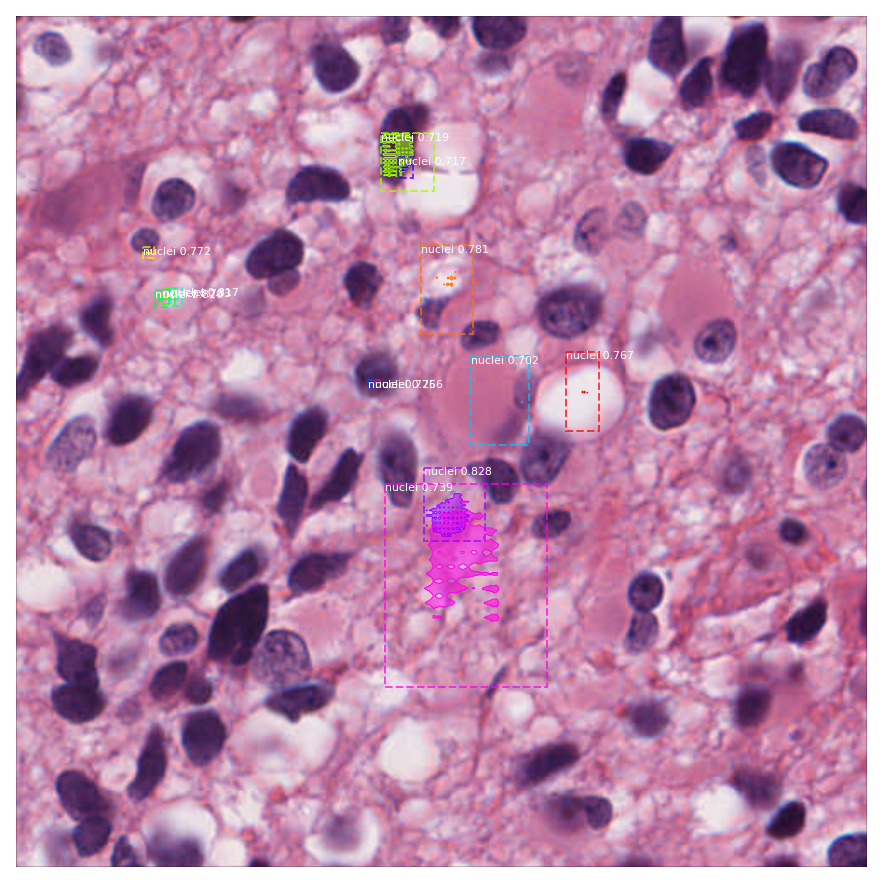

In [78]:
results = cpm17_model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            cpm17_dataset_val.class_names, r['scores'])

In [79]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 30 images. Increase for better accuracy.
image_ids = np.random.choice(cpm17_dataset_val.image_ids, 30)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(cpm17_dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = cpm17_model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

/content/drive/MyDrive/project_dataset/cpm17/test/Labels/image_21


ValueError: ignored

In [86]:
X_test = np.zeros((len(image_ids), cpm17_config.IMAGE_SHAPE[0], cpm17_config.IMAGE_SHAPE[1], 3), dtype=np.uint8)
sizes_test = []
_test_ids = []

print('Getting and resizing test images ... ')
#sys.stdout.flush()
for n, id_ in enumerate(image_ids):
    _test_ids.append([id_])
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:3]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (cpm17_config.IMAGE_SHAPE[0], cpm17_config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing test images ... 


NameError: ignored